## Modeling and forecasting atmospheric CO₂ from 1958 into the future

In [2]:
import pystan
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [3]:
from google.colab import files
uploaded = files.upload()

Saving weekly_in_situ_co2_mlo2.csv to weekly_in_situ_co2_mlo2.csv


In [4]:
import io
data = pd.read_csv(io.BytesIO(uploaded['weekly_in_situ_co2_mlo2.csv']), header = None, delimiter = ';')

In [5]:
data.head()

,0,1
0,1958-03-29,316.19
1,1958-04-05,317.31
2,1958-04-12,317.69
3,1958-04-19,317.58
4,1958-04-26,316.48


In [6]:
data[0] = data[0].astype('datetime64[ns]')

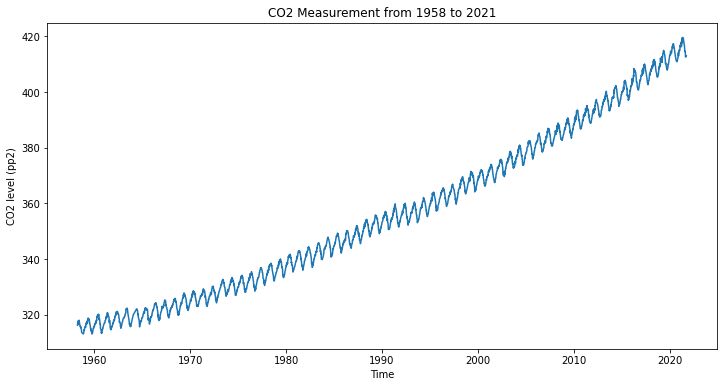

In [7]:
plt.figure(figsize=(12,6))
plt.xlabel('Time')
plt.ylabel('CO2 level (pp2)')
plt.title('CO2 Measurement from 1958 to 2021')
plt.plot(data[0], data[1])

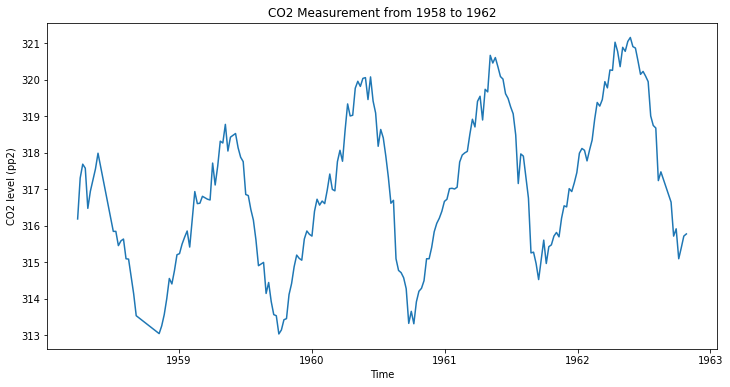

In [8]:
plt.figure(figsize=(12,6))
plt.xlabel('Time')
plt.ylabel('CO2 level (pp2)')
plt.title('CO2 Measurement from 1958 to 1962')
plt.plot(data[0][:218], data[1][:218])

In [9]:
# convert date to the number of days since first measurement
first_date = data[0].min()
data['time_delta'] = data[0] - first_date
data[4] = pd.to_timedelta(data.time_delta, errors='coerce').dt.days
data.head()

,0,1,time_delta,4
0,1958-03-29,316.19,0 days,0
1,1958-04-05,317.31,7 days,7
2,1958-04-12,317.69,14 days,14
3,1958-04-19,317.58,21 days,21
4,1958-04-26,316.48,28 days,28


In [58]:
test = [i for i in range(0, (datetime.datetime.fromisoformat('2060-01-01 00:00:00') - data[0].min()).days + 7, 7)]

In [74]:
dates = [datetime.datetime.fromisoformat('1958-03-29 00:00:00') + datetime.timedelta(days=7*i) for i in range(0, len(test))]

In [78]:
dates_str = [str(i) for i in dates]

In [59]:
# The Stan model. Running this cell compiles the Stan model, which takes
# some time.

stan_data = {
    'n': len(data), 
    'n_future': len(test) - len(data),
    'time': test,  # number of days - temperature
    'temp': data[1]
}

stan_code = """
data {
    int<lower=0> n_future; // The number of future values to predict
    int<lower=0> n;        // The number of data
    real<lower=0> time[n+n_future];          // Time data
    real temp[n];          // Temperature data
}

parameters {
    real<lower=0> b;               // intercept of the linear trend
    real<lower=0> k0;      // slope of the linear trend (positive)
    real<lower=0> k1;
    real<lower=0> A;      // Amplitude
    real<lower=0, upper=1> phi;               // Phi
    real<lower=0> sigma;      // Error term sigma
}

model {
    b ~ cauchy(0, 1);
    k0 ~ cauchy(0, 1);
    k1 ~ cauchy(0, 1);
    A ~ normal(0, 5);
    phi ~ normal(0, 1);
    sigma ~ gamma(1, 0.3);

    for(i in 1:n) {
      temp[i] ~ normal(b + k0 * time[i] + k1 * time[i]^2 + A * cos(2 * pi()*time[i] / 365.25 + phi), sigma);
    }
}

// Generate the predicted function values for the next n_future steps.
generated quantities {    
    
    real x_past[n];
    real x_future[n_future];

    for (i in 1:n) {
        x_past[i] = normal_rng(
            b + k0 * time[i] + k1 * time[i]^2 + A * cos(2*pi() * time[i] / 365.25 + phi), sigma);
    }

    for(i in 1:n_future) {
        x_future[i] = normal_rng(
            b + k0 * time[i+n] + k1 * time[i+n]^2 + A * cos(2*pi() * time[i+n] / 365.25 + phi), sigma);
    }
}
"""

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_38dff834ec51fdae6c4a07b655c9039e NOW.


In [60]:
results = stan_model.sampling(data=stan_data)
samples = results.extract()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


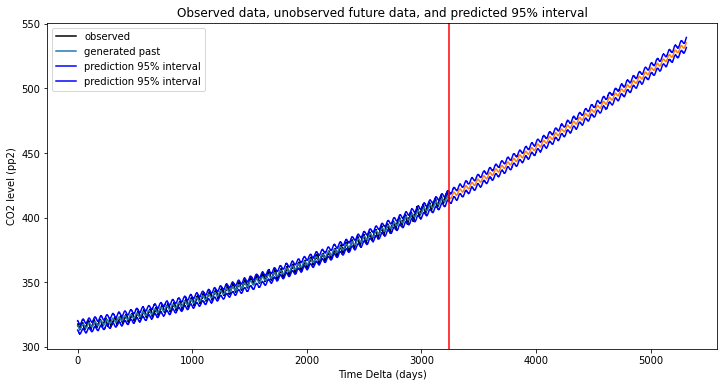

In [85]:
n_future = len(test) - len(data)
past = samples['x_past']
past_interval = np.percentile(past, axis=0, q=[2.5, 97.5])

prediction = samples['x_future']

# Compute 95% interval of the predicted values
prediction_interval = np.percentile(prediction, axis=0, q=[2.5, 97.5])

# Plot mean and 95% interval of predictions
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(data) + 1), data[1], 'k-', label='observed')

plt.plot(
    range(len(data)),
    np.mean(past, axis = 0),
    label='generated past'
)

plt.plot(
    range(len(data)),
    (past_interval[0,:]),
    'b-', label='prediction 95% interval')
plt.plot(
    range(len(data)),
    (past_interval[1,:]),
    'b-')

plt.plot(
    range(len(data), len(data) + n_future),
          np.mean(prediction, axis = 0))

plt.plot(
    range(len(data), len(data) + n_future + 1),
    np.concatenate((data[1][-1:], prediction_interval[0,:])),
    'b-', label='prediction 95% interval')
plt.plot(
    range(len(data), len(data) + n_future + 1),
    np.concatenate((data[1][-1:], prediction_interval[1,:])),
    'b-')

plt.axvline(len(data) - 1, color='red')
plt.xlabel('Time Delta (days)')
plt.ylabel('CO2 level (pp2)')
plt.legend()
plt.title('Observed data, unobserved future data, and predicted 95% interval')
plt.show()

In [63]:
# Run Hamiltonian Monte Carlo using Stan with 4 Markov chains, a 1000 step
# warm-up phase and 1000 step sampling phase for each chain. The warm-up samples
# are discarded, so we are left with 4 x 1000 = 4000 samples.

# This cell will take a minute or two to run.

parameters = ['b', 'k0', 'k1', 'A', 'phi', 'sigma']

print(results.stansummary(pars=parameters))

Inference for Stan model: anon_model_38dff834ec51fdae6c4a07b655c9039e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean      sd   2.5%     25%    50%    75%  97.5%  n_eff   Rhat
b     315.17  2.0e-3     0.1 314.98   315.1 315.17 315.23 315.35   2447    1.0
k0    2.2e-3  4.3e-7  2.0e-5 2.1e-3  2.1e-3 2.2e-3 2.2e-3 2.2e-3   2129    1.0
k1    1.0e-7 1.8e-11 8.5e-10 9.9e-8 10.0e-8 1.0e-7 1.0e-7 1.0e-7   2140    1.0
A       1.79  8.3e-4    0.05    1.7    1.76   1.79   1.82   1.88   2991    1.0
phi     0.63  4.6e-4    0.03   0.58    0.62   0.63   0.65   0.68   3138    1.0
sigma   1.87  4.3e-4    0.02   1.82    1.85   1.87   1.88   1.91   2991    1.0

Samples were drawn using NUTS at Wed Dec 15 16:04:38 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


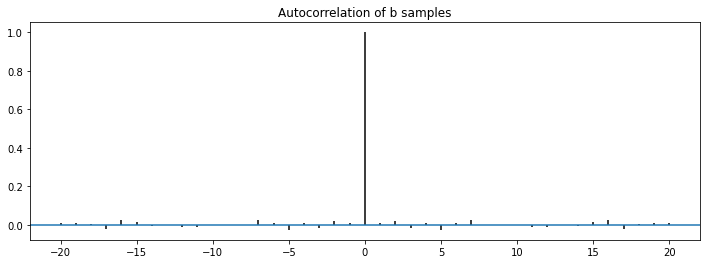

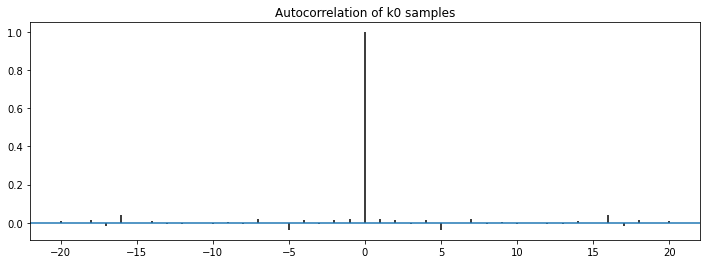

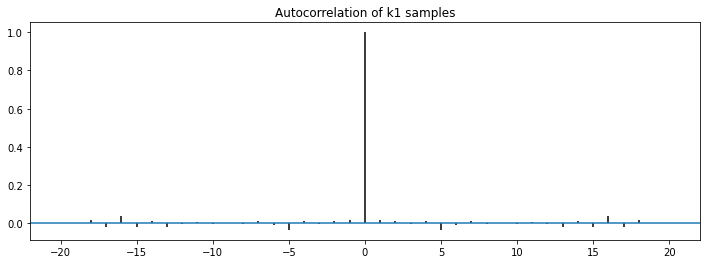

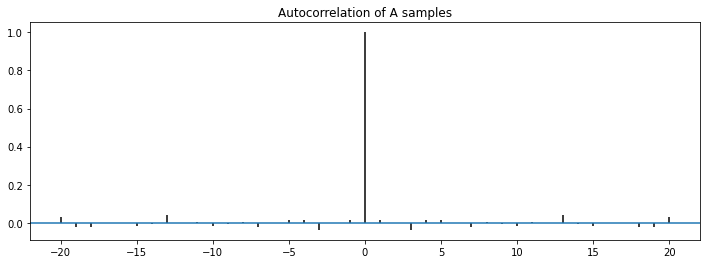

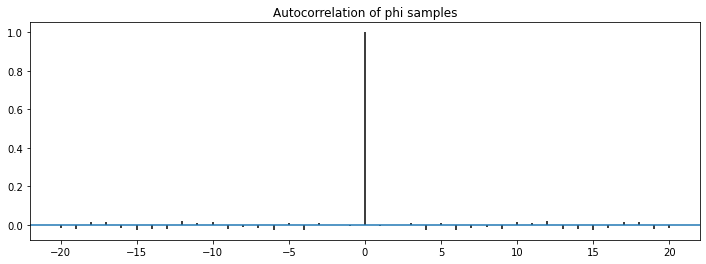

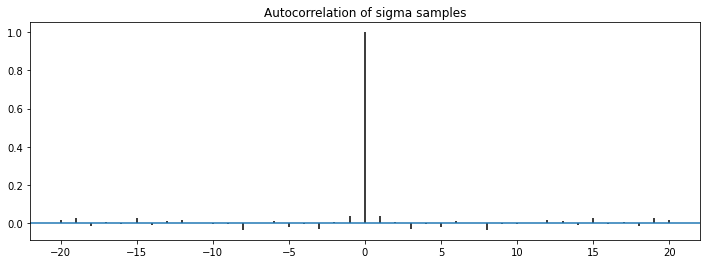

In [64]:
# Plot sample autocorrelation for each parameter.

def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))


for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


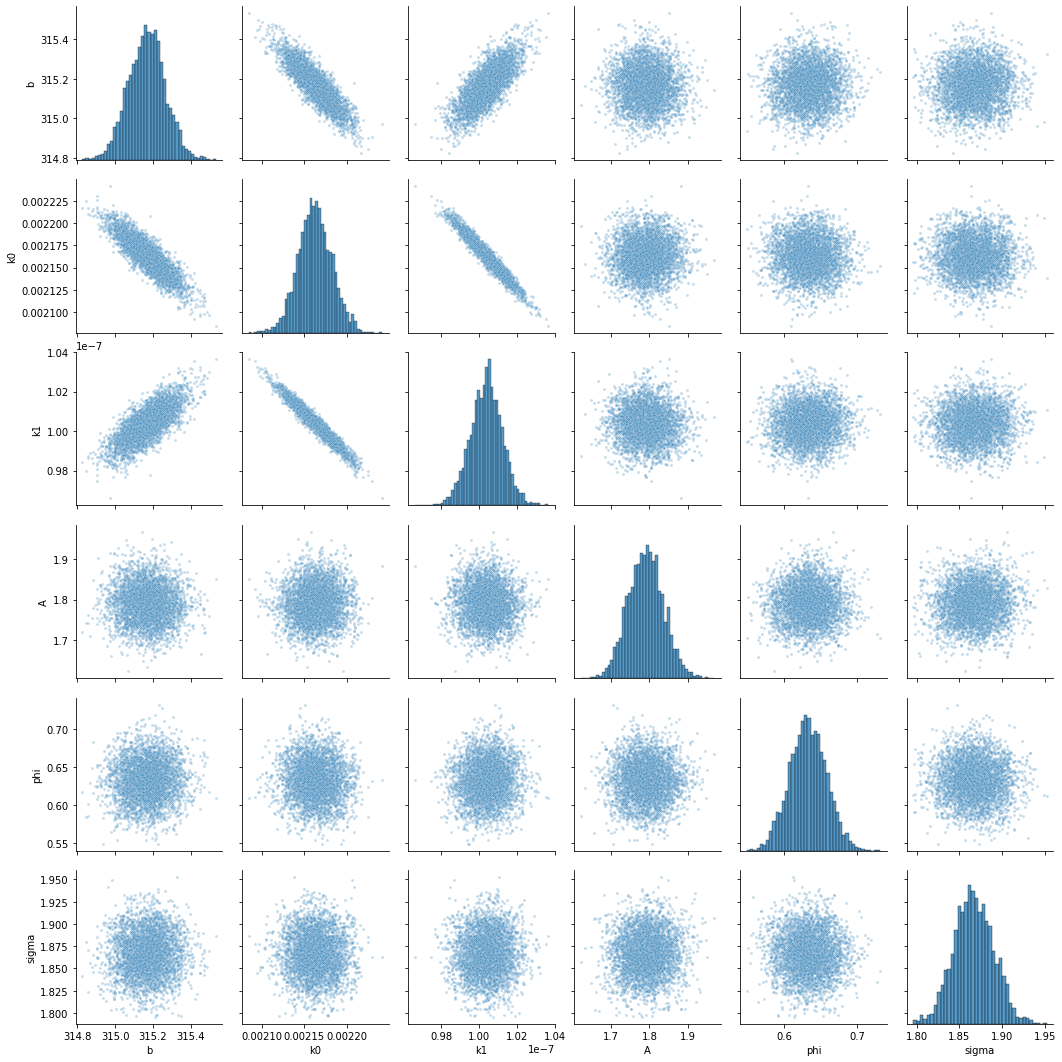

In [65]:
# Make pair plot of the posteriors over all parameters of the model.
df = pd.DataFrame(
    data=np.transpose([samples[param] for param in parameters]),
    columns=parameters)
seaborn.pairplot(df, size=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

In [66]:
mean_squared_error(data[1], np.mean(past, axis = 0))

3.478954480431631

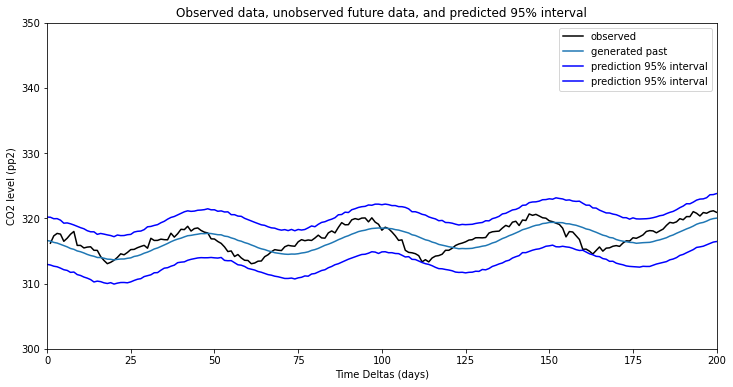

In [86]:
# Plot mean and 95% interval of predictions
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(data) + 1), data[1], 'k-', label='observed')

plt.xlim(0, 200)
plt.ylim(300, 350)

plt.plot(
    range(len(data)),
    np.mean(past, axis = 0),
    label='generated past'
)

plt.plot(
    range(len(data)),
    (past_interval[0,:]),
    'b-', label='prediction 95% interval')
plt.plot(
    range(len(data)),
    (past_interval[1,:]),
    'b-')

plt.plot(
    range(len(data), len(data) + n_future),
          np.mean(prediction, axis = 0))

plt.plot(
    range(len(data), len(data) + n_future + 1),
    np.concatenate((data[1][-1:], prediction_interval[0,:])),
    'b-', label='prediction 95% interval')
plt.plot(
    range(len(data), len(data) + n_future + 1),
    np.concatenate((data[1][-1:], prediction_interval[1,:])),
    'b-')

plt.axvline(len(data) - 1, color='red')
plt.xlabel('Time Deltas (days)')
plt.ylabel('CO2 level (pp2)')
plt.legend()
plt.title('Observed data, unobserved future data, and predicted 95% interval')
plt.show()

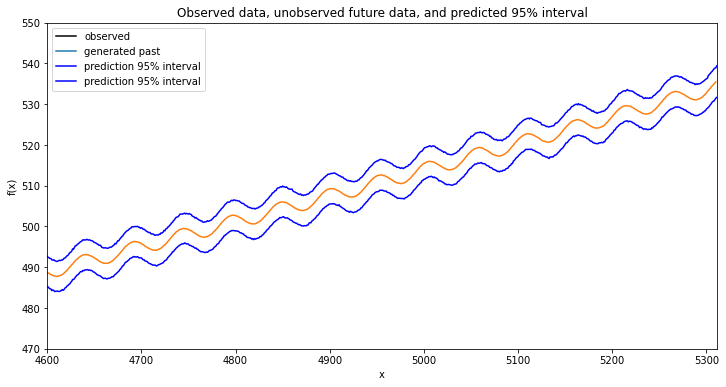

In [68]:
# Plot mean and 95% interval of predictions
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(data) + 1), data[1], 'k-', label='observed')

plt.xlim(4600, len(test))
plt.ylim(470, 550)

plt.plot(
    range(len(data)),
    np.mean(past, axis = 0),
    label='generated past'
)

plt.plot(
    range(len(data)),
    (past_interval[0,:]),
    'b-', label='prediction 95% interval')
plt.plot(
    range(len(data)),
    (past_interval[1,:]),
    'b-')

plt.plot(
    range(len(data), len(data) + n_future),
          np.mean(prediction, axis = 0))

plt.plot(
    range(len(data), len(data) + n_future + 1),
    np.concatenate((data[1][-1:], prediction_interval[0,:])),
    'b-', label='prediction 95% interval')
plt.plot(
    range(len(data), len(data) + n_future + 1),
    np.concatenate((data[1][-1:], prediction_interval[1,:])),
    'b-')

plt.axvline(len(data) - 1, color='red')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.title('Observed data, unobserved future data, and predicted 95% interval')
plt.show()

In [103]:
print(np.mean(prediction[:,-1]))

535.5044458848565


In [104]:
print(prediction_interval[:,-1])

[531.65584279 539.40671047]


In [105]:
data[0].min() + datetime.timedelta(days=7*(len(test)-1))

Timestamp('2060-01-03 00:00:00')

In [107]:
test2 = list(np.mean(past, axis=0)) + list(np.mean(prediction, axis=0))
pred = pd.DataFrame({'CO2': test2, 'date_str': dates_str})

In [116]:
np.mean(pred[5259:len(pred)]['CO2'])

532.54397704273

In [91]:
len(dates_str)

5311

In [138]:
pred[3900:3950]

,CO2,date_str
3900,450.024015,2032-12-25 00:00:00
3901,450.213359,2033-01-01 00:00:00
3902,450.422713,2033-01-08 00:00:00
3903,450.587615,2033-01-15 00:00:00
3904,450.815090,2033-01-22 00:00:00
3905,450.935701,2033-01-29 00:00:00
3906,451.078264,2033-02-05 00:00:00
3907,451.188596,2033-02-12 00:00:00
3908,451.241544,2033-02-19 00:00:00
3909,451.291815,2033-02-26 00:00:00


In [123]:
data[3200:]
(535.50 - 415.19)/415.19

0.28977094824056454

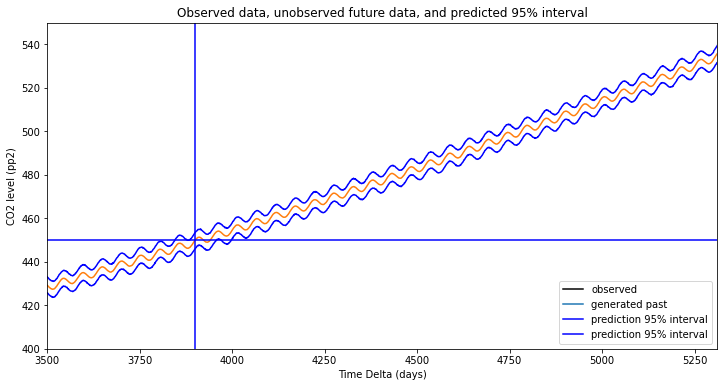

In [133]:
n_future = len(test) - len(data)
past = samples['x_past']
past_interval = np.percentile(past, axis=0, q=[2.5, 97.5])

prediction = samples['x_future']

# Compute 95% interval of the predicted values
prediction_interval = np.percentile(prediction, axis=0, q=[2.5, 97.5])

# Plot mean and 95% interval of predictions
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(data) + 1), data[1], 'k-', label='observed')

plt.plot(
    range(len(data)),
    np.mean(past, axis = 0),
    label='generated past'
)

plt.plot(
    range(len(data)),
    (past_interval[0,:]),
    'b-', label='prediction 95% interval')
plt.plot(
    range(len(data)),
    (past_interval[1,:]),
    'b-')

plt.plot(
    range(len(data), len(data) + n_future),
          np.mean(prediction, axis = 0))

plt.plot(
    range(len(data), len(data) + n_future + 1),
    np.concatenate((data[1][-1:], prediction_interval[0,:])),
    'b-', label='prediction 95% interval')
plt.plot(
    range(len(data), len(data) + n_future + 1),
    np.concatenate((data[1][-1:], prediction_interval[1,:])),
    'b-')

plt.xlim(3500,5310)
plt.ylim(400, 550)
plt.axvline(3900, color='blue')
plt.axhline(450, color='blue')
plt.axvline(len(data) - 1, color='red')
plt.xlabel('Time Delta (days)')
plt.ylabel('CO2 level (pp2)')
plt.legend()
plt.title('Observed data, unobserved future data, and predicted 95% interval')
plt.show()

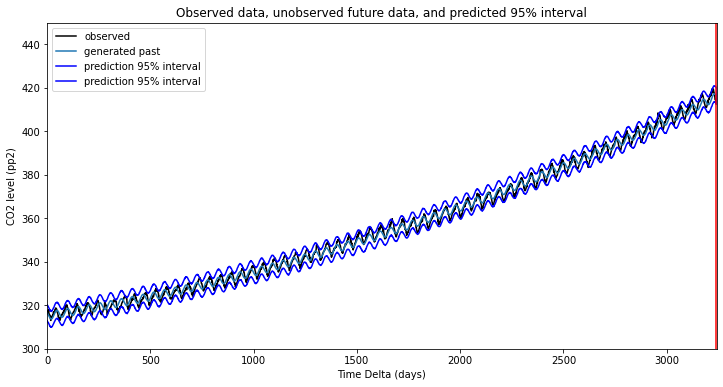

In [142]:
# Plot mean and 95% interval of predictions
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(data) + 1), data[1], 'k-', label='observed')

plt.xlim(0, len(data))
plt.ylim(300, 450)

plt.plot(
    range(len(data)),
    np.mean(past, axis = 0),
    label='generated past'
)

plt.plot(
    range(len(data)),
    (past_interval[0,:]),
    'b-', label='prediction 95% interval')
plt.plot(
    range(len(data)),
    (past_interval[1,:]),
    'b-')

plt.plot(
    range(len(data), len(data) + n_future),
          np.mean(prediction, axis = 0))

plt.plot(
    range(len(data), len(data) + n_future + 1),
    np.concatenate((data[1][-1:], prediction_interval[0,:])),
    'b-', label='prediction 95% interval')
plt.plot(
    range(len(data), len(data) + n_future + 1),
    np.concatenate((data[1][-1:], prediction_interval[1,:])),
    'b-')

plt.axvline(len(data) - 1, color='red')
plt.xlabel('Time Delta (days)')
plt.ylabel('CO2 level (pp2)')
plt.legend()
plt.title('Observed data, unobserved future data, and predicted 95% interval')
plt.show()